# Budget Testing

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## Consistency check: Are the reconstructed dzt values good enough?
All simulations have the 'dzt' averages saved in the `ocean_budget` files. But for CM2.6 this would mean staging another 7TB.
So here I will test if the 'reconstruction' using SSH is sufficiently accurate

In [2]:
from mom_read import open_mom5_CM_ESM
# from mom_budgets import calculate_dzstar, calculate_dz
from mom_budgets import calculate_ds, calculate_dz
from xarrayutils.utils import concat_dim_da

runnames = ['control']
years = range(181,201)
rho = 1035 # Constant reference density

In [3]:
# old version...I have since removed the files and only left the zarr versions
# cm21_varlist =['ocean', 'ocean_budgets'] # This is a bit different in CM2.6...lets unify this..., #'ocean_trans', 'ocean_budgets', 
# cm21_gridfile = '/work/Julius.Busecke/CM2.1/siena_201303_fix_rds/static/grid_complete.nc'
# ddir_cm21_control = '/work/Julius.Busecke/CM2.1/siena_201303_fix_rds/CM_O1p0_C180_A02-topaz-bling-minibling-ctrl-restart_bgc/pp'
# ds = open_mom5_CM_ESM(ddir_cm21_control, varfolderlist=cm21_varlist, gridfile=cm21_gridfile, years=years)

# ds = xr.open_zarr('/work/Julius.Busecke/zarr_conversions/CM21deg.zarr/')
ds = xr.open_zarr('/work/Julius.Busecke/zarr_conversions/CM26.zarr/')

# Reconstructing the vertical spacing
I am trying to move along the lines of the [MOM5 manual]() here.
In order to allow for a free surface but avoid vanishing top and bottom cells the actual vertical levels are scaled as $ z^{*} = H \frac{(z-\eta)}{(H + \eta)}$ with $\eta$ as the free surface and $H$ as the bottom depth.
(section 5.1.4)

Using the $z^{*}$ coordinate system in MOM means setting the vertical coordinate $s$ to $s=z^{*}$. From this follows that the range of $z^*$ is time independent, but the specific thickness of each cell is not!

It is given by $ dz = (1 + \frac{\eta}{H}) dz^* = (1 + \frac{\eta}{H}) ds$, if I understand the notation.

I reconstruct $dst$ and $dswt$ (static vertical cell thickness for tracer cells) using the difference between the `st_ocean_edges` and `swt_ocean_edges` fields from the grid file.

See `calculate_ds` in `mom_budgets.py`.

There is an added complication when using partial bottom cells: If I understand this correctly, the condition to be met is that the static thicknesses have to sum up to the static ocean depth, e.g.
$\sum_k ds = \sum_k dz^* = H$ where k is the vertical grid index.

So lets try to implement this additional complication:



In [7]:
# This should only work for the tracer cell points. Vel points are calculated as minimum of the sourrounding cells.
# Not entirely sure about the dswt distances....Can the bottom u cells have a different depth than the t cells?
test = calculate_ds(ds)
# roi = dict(yt_ocean=30, xt_ocean=5) # for the low res version
roi = dict(yt_ocean=1000, xt_ocean=300)
test.isel(**roi).load()

<xarray.DataArray 'sub-8bbd05b2c73157c0b6e851aaecdcc234' (st_ocean: 50)>
array([ 10.0671  ,  10.0929  ,  10.128901,  10.178499,  10.247402,  10.342697,
        10.474804,  10.6576  ,  10.910194,  11.259605,  11.741699,  12.406197,
        13.320007,  14.572601,  16.282898,  18.604599,  21.732391,  25.902603,
        31.38681 ,  38.469788,  47.407104,  58.359283,  71.308716,  85.988373,
       101.854797, 118.145203, 134.011597, 148.691284, 161.640747, 172.592896,
       181.530273, 188.613159, 194.097412, 198.267456, 201.395508, 203.717041,
       205.42749 , 206.679932, 207.593994, 208.258057, 208.740479, 209.089844,
       209.342285, 209.525391, 209.657227, 209.752441,  59.455741,        nan,
              nan,        nan])
Coordinates:
  * st_ocean      (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
    area_t        float64 1.036e+08
    dxt           float64 1.018e+04
    dyt           float64 1.018e+04
    geolat_t      float64 -23.74
    geolon_t      float64 -249.

In [8]:
# This is the total static (just vertical version)
ds.coords['dst'] = calculate_ds(ds, 'st')

In [9]:
# # so there is a problem with the bottom cells
# # lets mask out the last tracer value at the bottom
# bottom_idx = (~xr.ufuncs.isnan(ds.temp)).sum('st_ocean') -1
# bottom_idx

# dummy_depth = xr.DataArray(np.arange(len(ds.st_ocean)), dims=['st_ocean'])
# dummy_count = ((ds.temp.fillna(0) * 0) + 1) * dummy_depth
# mask = dummy_count >= bottom_idx

# ughhh crap. The zarr version does not have the rho_dzt values?
Ill have to fix that. But for now I can see if I can reconstruct the budget correctly.

In [15]:
# dzt_reconstructed = calculate_dz(ds.eta_t, ds.ht, ds.dst)
# # dzt_reconstructed_masked = dzt_reconstructed.where(~mask)
# dzt_true = ds.rho_dzt / rho

In [16]:
# # Calculate the relative error 
# abs_error = dzt_reconstructed_masked - dzt_true
# rel_error = abs_error / dzt_true

In [17]:
# # Single example
# roi = dict(time=3, xt_ocean=100, yt_ocean=10)
# sample = xr.Dataset({'recon': dzt_reconstructed_masked, 'true': dzt_true, 'abs_err': abs_error, 'rel_err': rel_error,})
# sample = sample.isel(**roi).load()
# # idx = bottom_idx.isel(**roi).load()
# # sample['recon'][{'st_ocean':slice(idx.data,None)}] = np.nan
# # print(idx)

# sample['true'].plot()
# sample['recon'].plot(linestyle='--')
# sample['abs_err'].plot()


# plt.figure(figsize=[12,5])
# sample['rel_err'].plot()

In [18]:
# abs(abs_error*100).plot(bins=np.linspace(0, 1e-3, 21));

In [19]:
# (abs_error*100).max().load()

## Summary
- The reconstruction does not take into account the partial cell at the bottom
- The error is exceedingly small. 2/1000 of a percent at max

## Checking the dzu reconstruction

[[47.40450067 47.40486825]
 [47.40500328 47.40544141]]
47.404500669758846
47.404500669758846


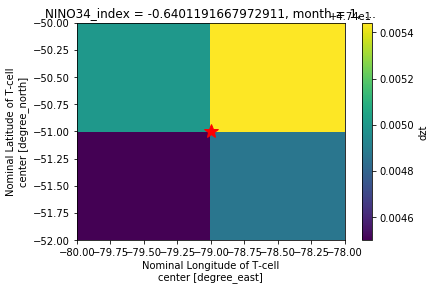

In [3]:
from mom_budgets import add_vertical_spacing
ds_test = xr.open_zarr('/work/Julius.Busecke/zarr_test/CM21deg_control.zarr')
ds_test = add_vertical_spacing(ds_test)

# Confirming that the dzu is the min of the sourrounding 4 dzt values
dzt = ds_test.dzt.isel(time=0, st_ocean=20, xt_ocean=slice(200, 202), yt_ocean=slice(30, 32))
dzu = ds_test.dzu.isel(time=0, st_ocean=20, xu_ocean=200, yu_ocean=30)
print(dzt.load().data)
print(dzt.min().load().data)
print(dzu.load().data)
dzt.plot()
plt.plot(dzu.xu_ocean, dzu.yu_ocean, marker='*',markersize=15, color='r')

## Test the advective tendency split
- There are some problems at the bottom cells (prob caused by the faulty computation of partial cells...need to fix that upstream)
- The results are not perfect, because I cannot represent the advection operator exactly and I am reconstructing from monthly averages...
- Overall though, I would say this looks quite all right, Id have to check the actual mass transports. These are only affected by the latter.

In [10]:
from mom_budgets import add_split_tendencies
# def add_split_tendencies(ds):
#     """Reconstructs various fluxes and tendencies (x-y_x) from the monthly averaged output. Hardcoded to o2 atm."""
#     ds = ds.copy()
#     rho = 1035 #reference density
#     grid = Grid(ds)
    
#     # Calculate thickness weighted mass transports from velocities according to MOM5 formulation
#     uhrho_et, vhrho_nt, wrhot = reconstruct_hrho_trans(ds.u, ds.v, ds.wt, ds.dzt * rho, ds.dzu * rho, grid, rho)
    
#     # Reconstruct the flux terms
#     ds['o2_xflux_adv_recon'], ds['o2_yflux_adv_recon'], ds['o2_zflux_adv_recon'] = \
#         approximate_transport_op(uhrho_et, vhrho_nt, wrhot, ds['o2'], grid, boundary='extend')
    
#     # Reconstruct flux terms seperately for 
    
    
#     # Calculate tendencies from all advective fluxes
#     for suffix in ['', '_recon', 'recon_tracer', 'recon_vel']:
#         ds['o2_advection_x'+suffix], \
#         ds['o2_advection_y'+suffix], \
#         ds['o2_advection_z'+suffix] = tend_from_fluxes(ds['o2_xflux_adv'+suffix],
#                                                        ds['o2_yflux_adv'+suffix],
#                                                        ds['o2_zflux_adv'+suffix], grid)
    
    

# #     # some interpolations... might want to remap these in the future, to get more accurate estimates
# #     u = grid.interp(ds['u'], 'Y')
# #     v = grid.interp(ds['v'], 'X')
# #     wt = ds['wt']
# # #     dxte = grid.interp(ds.dxu, 'Y')
# # #     dytn = grid.interp(ds.dyu, 'X')
    
    

# #     # o2_flux reconstructed from tracer and velocity field (vel*tracer*dyt*dzt*rho)
# #     # Are the values actually interpolated or do they take the center tracer value? Read up in MOM5 manual and correct if needed.
# #     # This will need some more advanced testing...in the end we cannot really reproduce the complex advection scheme, but it is worth trying
# # #     # to get as close as possible.
# # #     ds['o2_xflux_adv_recon'] = grid.interp(ds['o2'], 'X') * u * ds.dzt * ds.dyte * rho
# # #     ds['o2_yflux_adv_recon'] = grid.interp(ds['o2'], 'Y') * v * ds.dzt * ds.dxtn * rho
# # #     ds['o2_zflux_adv_recon'] = grid.interp(ds['o2'], 'Z') * wt * ds.dxt * ds.dyt * rho

# #     # Reconstruct the advective tendencies (as (tracer* s^-1) * dzt * rho)
# #     # also not sure about the numerics here...this implements finite difference approach...which mom used for some variables but not all...

# #     ds['o2_advection_x_recon_full'] = - (grid.diff(ds['o2_xflux_adv_recon'], 'X') / ds.area_t)
# #     ds['o2_advection_x_recon_du'] = - (ds['o2'] * grid.diff(u, 'X') / ds.dxt * ds.dzt * rho)
# #     ds['o2_advection_x_recon_do2'] = - (u * grid.diff(ds['o2'], 'X') / dxte * ds.dzt * rho)

# #     ds['o2_advection_y_recon_full'] = - (grid.diff(ds['o2_yflux_adv_recon'], 'Y') / ds.area_t)
# #     ds['o2_advection_y_recon_dv'] = - (ds['o2'] * grid.diff(v, 'Y') / ds.dyt * ds.dzt * rho)
# #     ds['o2_advection_y_recon_do2'] = - (v * grid.diff(ds['o2'], 'Y') / dytn * ds.dzt * rho)

# #     ds['o2_advection_z_recon_full'] =  (grid.diff(ds['o2_zflux_adv_recon'], 'Z') / ds.area_t)
# #     ds['o2_advection_z_recon_dwt'] =  (ds['o2'] * grid.diff(wt, 'Z') * rho)
# #     ds['o2_advection_z_recon_do2'] =  (wt * grid.diff(ds['o2'], 'Z') * rho)
#     return ds

In [11]:
%load_ext autoreload
%autoreload 1
%aimport mom_budgets
from mom_budgets import add_vertical_spacing, add_split_tendencies
# ds_test = xr.open_zarr('/work/Julius.Busecke/zarr_test/CM21deg_control.zarr')
ds_test = xr.open_zarr('/work/Julius.Busecke/zarr_test/CM26_control.zarr')
ds_test = add_vertical_spacing(ds_test)

In [13]:
ds_test = add_split_tendencies(ds_test)

Vertical spacing for vertical vel cell is approximated!!! Use with caution
Spacing for `dxte` is approximated!!! Use with caution
Spacing for `dytn` is approximated!!! Use with caution


/home/Julius.Busecke/code/miniconda/envs/standard/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/Julius.Busecke/code/miniconda/envs/standard/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


AttributeError: Unknown property robust

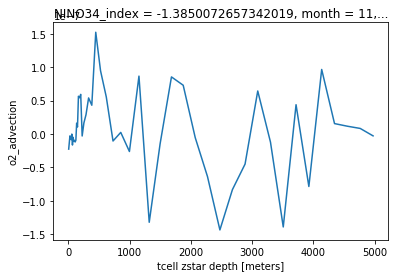

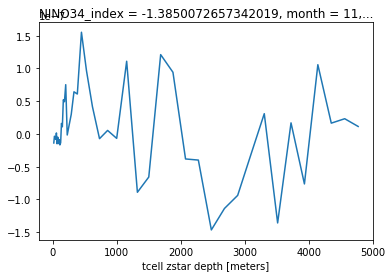

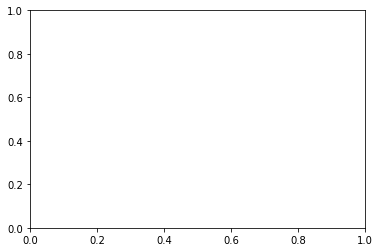

In [22]:
# is the reconstruction of the tendencies from the saved (full) fluxes exact?

# def subset(ds):
#     return ds.isel(time=10).sel(yt_ocean=0, method='nearest').sel(xt_ocean=slice(-250, -225))

def subset(ds):
    return ds.isel(time=10).sel(yt_ocean=slice(-1,1)).sel(xt_ocean=-225, method='nearest').mean('yt_ocean')

true = ds_test['o2_advection']
new = ds_test['o2_advection_x'] + ds_test['o2_advection_y'] + ds_test['o2_advection_z']

plt.figure()
subset(true).plot()


plt.figure()
subset(new).plot()


plt.figure()
subset((new - true)).plot(robust=True)

# plt.figure()
# (((new - true) / true) * 100).plot(bins=np.linspace(-0.2,0.2,50))
# plt.gca().set_yscale('log')

### more tests....

(array([3.3808000e+05, 3.6430300e+05, 3.9262000e+05, 4.2679500e+05,
        4.6433100e+05, 5.0744400e+05, 5.5787100e+05, 6.1760800e+05,
        6.8606300e+05, 7.6905400e+05, 8.6739100e+05, 9.8610200e+05,
        1.1337510e+06, 1.3130710e+06, 1.5406800e+06, 1.8339310e+06,
        2.2274330e+06, 2.7648230e+06, 3.5420640e+06, 4.7309670e+06,
        6.7027050e+06, 1.0339452e+07, 1.8404681e+07, 4.6506701e+07,
        1.8037444e+08, 4.8047509e+07, 1.9337144e+07, 1.0958029e+07,
        7.1681990e+06, 5.0957440e+06, 3.8306860e+06, 2.9931490e+06,
        2.4124540e+06, 1.9895760e+06, 1.6709790e+06, 1.4248200e+06,
        1.2283860e+06, 1.0717010e+06, 9.4318500e+05, 8.3825500e+05,
        7.4823100e+05, 6.7298900e+05, 6.0931400e+05, 5.5230600e+05,
        5.0558500e+05, 4.6287800e+05, 4.2582100e+05, 3.9278100e+05,
        3.6680600e+05]),
 array([-5.        , -4.79591837, -4.59183673, -4.3877551 , -4.18367347,
        -3.97959184, -3.7755102 , -3.57142857, -3.36734694, -3.16326531,
        -2.95

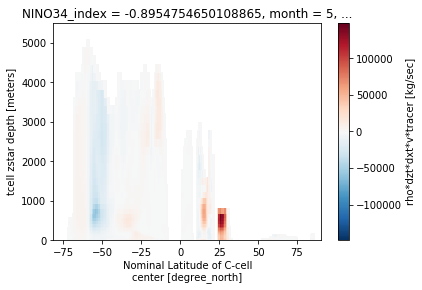

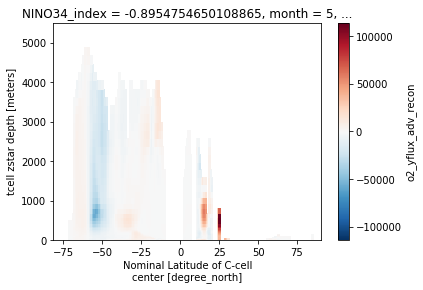

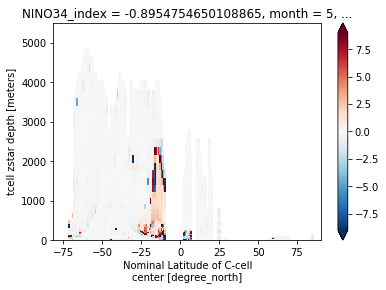

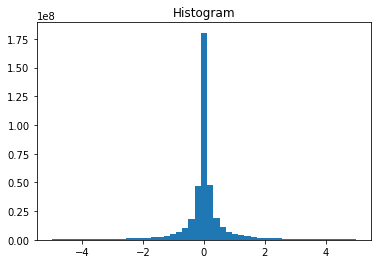

In [45]:
# How well do we reconstruct the actual fluxes (this is probably the toughest test...)
roi = dict(time=4, xu_ocean=200)
fld = 'o2_xflux_adv'

roi = dict(time=4, xt_ocean=200)
fld = 'o2_yflux_adv'

# roi = dict(time=4, xt_ocean=250)
# fld = 'o2_zflux_adv'

plt.figure()
ds_test['%s' %fld].isel(**roi).plot()

plt.figure()
ds_test['%s_recon' %fld].isel(**roi).plot()

plt.figure()
(((ds_test['%s_recon' %fld] - ds_test['%s' %fld]) / ds_test['%s' %fld]) * 100).isel(**roi).plot(robust=True)

plt.figure()
(((ds_test['%s_recon' %fld] - ds_test['%s' %fld]) / ds_test['%s' %fld]) * 100).plot(bins=np.linspace(-5, 5, 50))

/home/Julius.Busecke/code/miniconda/envs/standard/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


(array([7.59405000e+05, 8.12915000e+05, 8.70180000e+05, 9.38676000e+05,
        1.01303200e+06, 1.09617700e+06, 1.19272400e+06, 1.30356700e+06,
        1.42942800e+06, 1.57727800e+06, 1.74833800e+06, 1.95181500e+06,
        2.19408700e+06, 2.49087900e+06, 2.85754200e+06, 3.31804900e+06,
        3.90823200e+06, 4.69591200e+06, 5.75967800e+06, 7.29197500e+06,
        9.61159600e+06, 1.34715660e+07, 2.09029530e+07, 4.02337370e+07,
        1.05273785e+08, 3.97729070e+07, 2.05158520e+07, 1.31599740e+07,
        9.35633000e+06, 7.06391200e+06, 5.56787600e+06, 4.51661100e+06,
        3.75308500e+06, 3.17802300e+06, 2.72793100e+06, 2.37397100e+06,
        2.08738300e+06, 1.84606500e+06, 1.65179800e+06, 1.48457800e+06,
        1.34333300e+06, 1.21905900e+06, 1.11466600e+06, 1.02484200e+06,
        9.43982000e+05, 8.71084000e+05, 8.07492000e+05, 7.51320000e+05,
        6.99010000e+05]),
 array([-5.        , -4.79591837, -4.59183673, -4.3877551 , -4.18367347,
        -3.97959184, -3.7755102 , -3.

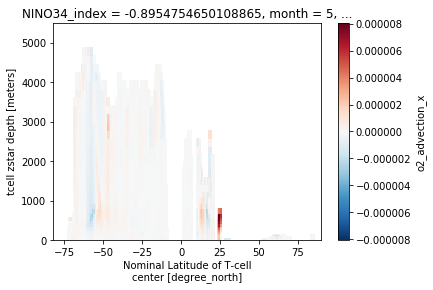

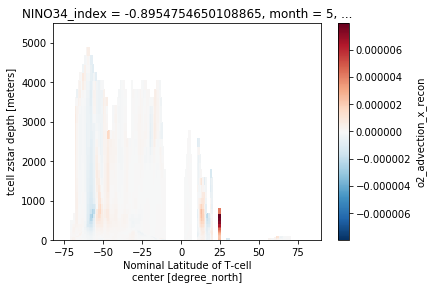

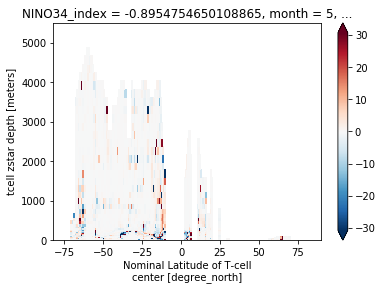

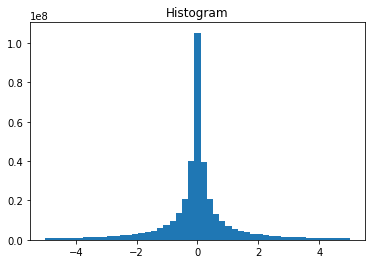

In [48]:
# Test if the decomposition works
plt.figure()
ds_test['o2_advection_x'].isel(**roi).plot()


plt.figure()
ds_test['o2_advection_x_recon'].isel(**roi).plot()



error = ((ds_test['o2_advection_x_recon'] - ds_test['o2_advection_x']) / ds_test['o2_advection_x']) * 100
plt.figure()
error.isel(**roi).plot(robust=True)

plt.figure()
error.where(xr.ufuncs.isfinite(error)).plot(bins=np.linspace(-5,5,50))
# plt.gca().set_yscale('log')

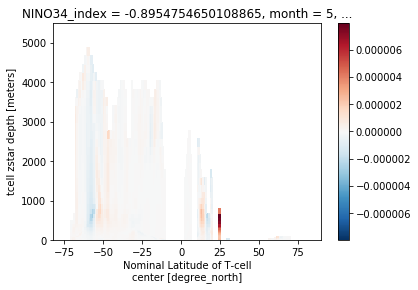

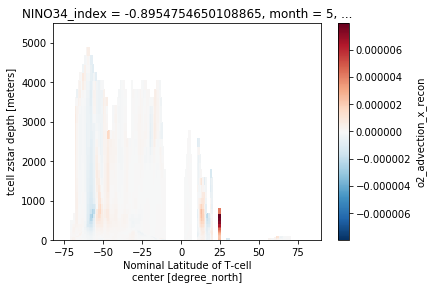

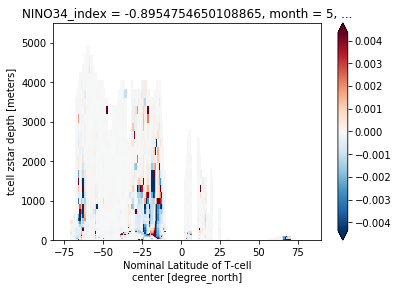

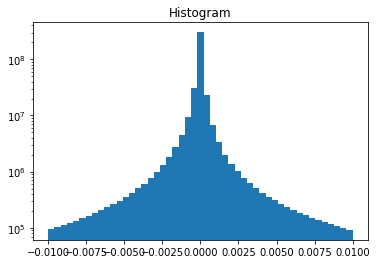

In [51]:
# Test the tracergrad/vel-divergence decomposition.
plt.figure()
(ds_test['o2_advection_x_recon_vel'] + ds_test['o2_advection_x_recon_tracer']).isel(**roi).plot()

plt.figure()
ds_test['o2_advection_x_recon'].isel(**roi).plot()

error = (((ds_test['o2_advection_x_recon_vel'] + ds_test['o2_advection_x_recon_tracer']) - ds_test['o2_advection_x_recon']) / ds_test['o2_advection_x_recon']) * 100
plt.figure()
error.isel(**roi).plot(robust=True)

plt.figure()
error.where(xr.ufuncs.isfinite(error)).plot(bins=np.linspace(-0.01,0.01,50))
plt.gca().set_yscale('log')

This seems good for now. Ready for the EUC_shape paper preprocessing.

Vertical spacing for vertical vel cell is approximated!!! Use with caution
Spacing for `dxte` is approximated!!! Use with caution
Spacing for `dytn` is approximated!!! Use with caution


/home/Julius.Busecke/code/miniconda/envs/standard/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/home/Julius.Busecke/code/miniconda/envs/standard/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/home/Julius.Busecke/code/miniconda/envs/standard/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/home/Julius.Busecke/code/miniconda/envs/standard/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


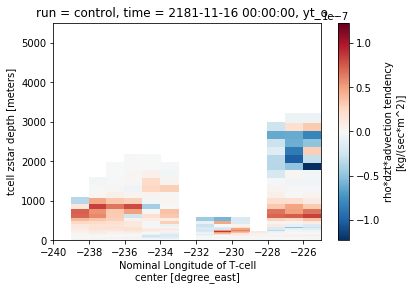

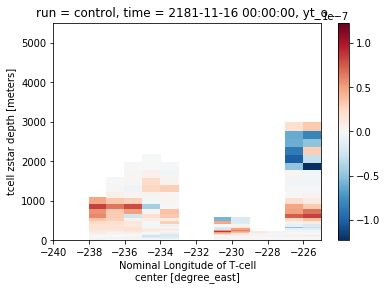

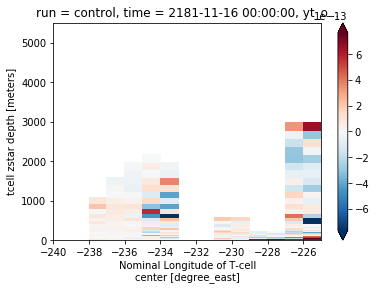

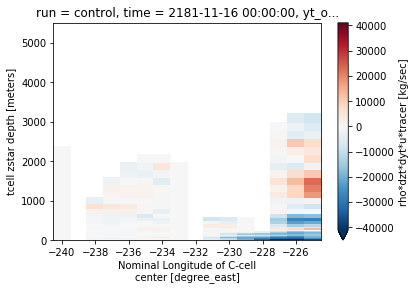

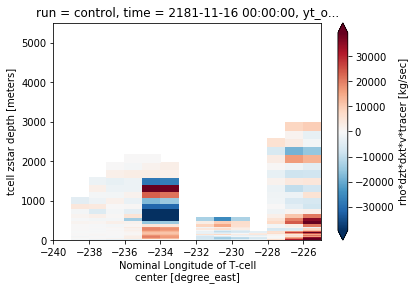

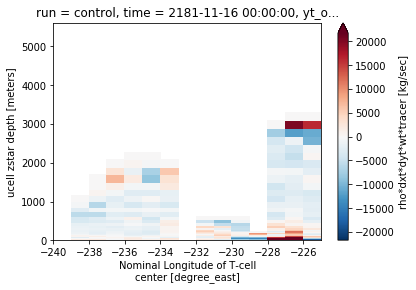

In [68]:
########### Check in detail what is happening around the Galapagos
from mom_budgets import add_split_tendencies
ds_add = add_split_tendencies(add_vertical_spacing(ds))
ds_gal = ds_add.sel(yt_ocean=0, yu_ocean=0, method='nearest').sel(xt_ocean=slice(-240, -225), xu_ocean=slice(-95, -225)).isel(time=10, run=0)

true = ds_gal.o2_advection
test = (ds_gal.o2_advection_x + ds_gal.o2_advection_y + ds_gal.o2_advection_z)

plt.figure()
true.plot()

plt.figure()
test.plot()

plt.figure()
(test - true).plot(robust=True)

# for var in ['x', 'y', 'z']:
#     plt.figure()
#     ds_gal['o2_%sflux_adv' %var].plot(robust=True)


In [60]:
ds_gal

<xarray.Dataset>
Dimensions:                (nv: 2, st_edges_ocean: 51, st_ocean: 50, st_ocean_sub02: 10, sw_edges_ocean: 51, sw_ocean: 50, xt_ocean: 15, xu_ocean: 360, yu_ocean: 200)
Coordinates:
    area_e                 (xu_ocean) float64 dask.array<shape=(360,), chunksize=(360,)>
    area_n                 (yu_ocean, xt_ocean) float64 dask.array<shape=(200, 15), chunksize=(200, 15)>
    area_t                 (xt_ocean) float64 dask.array<shape=(15,), chunksize=(15,)>
    area_u                 (yu_ocean, xu_ocean) float64 dask.array<shape=(200, 360), chunksize=(200, 360)>
    dxt                    (xt_ocean) float64 dask.array<shape=(15,), chunksize=(15,)>
    dxtn                   (yu_ocean, xt_ocean) float64 dask.array<shape=(200, 15), chunksize=(200, 15)>
    dxu                    (yu_ocean, xu_ocean) float64 dask.array<shape=(200, 360), chunksize=(200, 360)>
    dyt                    (xt_ocean) float64 dask.array<shape=(15,), chunksize=(15,)>
    dyte                   (x